In [2]:
# first we need to import the libraries we're going to use
# 'import x as y' will import package x but give it the alias 'y' so you don't have to type out x all the time

import matplotlib.pyplot as plt # for making nice plots
import sklearn as skl # for the machine learning bit!
import pandas as pd # for handling and transforming the data
import numpy as np # for useful numerical operations
import graphviz # for visualizing our decision tree
import lime # for visualizing tree model predictions
import datetime # for manipulating dates, timestamps etc

%matplotlib inline

## Part 1 - loading and cleaning the data (10 mins)

### Part 1a - loading and exploring the data

In [3]:
# load in the csv of our data, without specifying any options
dataPath = "../data/raw.csv"
df = pd.read_csv(dataPath)

In [4]:
# use the head function to see the top N rows of the dataframe
df.head(5)

,reference_num,easting,northing,num_vehicles,accident_date,accident_time,road_class,road_surface,lighting,weather,casualty_class,casualty_severity,casualty_sex,casualty_age,vehicle_type
0,3109,427890,430474,1,05-Jan-09,705,A,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,Pedestrian,Serious,Male,18,Car
1,70609,439643,436962,3,28-Jan-09,1530,Unclassified,Wet / Damp,Daylight: street lights present,Fine without high winds,Driver,Serious,Male,75,Car
2,321309,437814,429825,3,25-Apr-09,1803,A,Dry,Daylight: street lights present,Fine without high winds,Driver,Serious,Male,39,Car
3,321309,437814,429825,3,25-Apr-09,1803,A,Dry,Daylight: street lights present,Fine without high winds,Passenger,Serious,Male,16,Car
4,321309,437814,429825,3,25-Apr-09,1803,A,Dry,Daylight: street lights present,Fine without high winds,Passenger,Serious,Male,12,Car


In [5]:
# what columns do we have? Iterate over the columns in the dataframe and see what sort of data they contain
# hint at the bottom!

for columnName in list(df.columns):
    valType = type(df.iloc[0][columnName])
    print("{} - type = {}".format(columnName, valType))
    
# hint: df.columns returns the column names, df[columnName].values returns the values as a series

reference_num - type = <class 'str'>
easting - type = <class 'numpy.int64'>
northing - type = <class 'numpy.int64'>
num_vehicles - type = <class 'numpy.int64'>
accident_date - type = <class 'str'>
accident_time - type = <class 'numpy.int64'>
road_class - type = <class 'str'>
road_surface - type = <class 'str'>
lighting - type = <class 'str'>
weather - type = <class 'str'>
casualty_class - type = <class 'str'>
casualty_severity - type = <class 'str'>
casualty_sex - type = <class 'str'>
casualty_age - type = <class 'numpy.int64'>
vehicle_type - type = <class 'str'>


In [6]:
# numerical columns - is everything a number? a sensible number?

numericalColumnsToCheck = ['num_vehicles', 'casualty_age']

for column in numericalColumnsToCheck:
    valuesPresent = list(set(df[column].values))
    print("{} - min = {}, max = {}".format(column, min(valuesPresent), max(valuesPresent)))
    print("-------")

num_vehicles - min = 1, max = 14
-------
casualty_age - min = 0, max = 98
-------


In [7]:
# categorical columns

# decide which columns you can check contain the correct categories
columnsToCheck = ['road_class', 'road_surface', 'lighting', 'weather', 'casualty_class',
                 'casualty_severity', 'casualty_sex', 'vehicle_type']

# go through these columns and check that the values we have are expected
for column in columnsToCheck:
    valuesPresent = set(df[column].values)
    print("{} - {}".format(column, str(valuesPresent)))
    print("-------")

road_class - {'A(M)', 'C', 'B', 'Motorway', 'Unclassified', 'A'}
-------
road_surface - {nan, '5', 'Flood (surface water over 3cm deep)', 'Snow', 'Wet / Damp', 'Flood', 'Frost/ Ice', 'Dry', 'Frost / Ice'}
-------
lighting - {'Darkness: no street lighting', 'Darkness: street lights present but unlit', 'Daylight: street lights present', 'Darkness: street lighting unknown', '5', 'Darkness: street lights present and lit'}
-------
weather - {'Fog or mist \x96 if hazard', 'Unknown', 'Other', 'Snowing without high winds', 'Darkness: street lighting unknown', 'Snowing with high winds', 'Fine without high winds', 'Raining with high winds', 'Raining without high winds', 'Fine with high winds'}
-------
casualty_class - {'Passenger', 'Driver/Rider', 'Pedestrian', 'Driver'}
-------
casualty_severity - {'Slight', 'Serious'}
-------
casualty_sex - {'Male', 'Female'}
-------
vehicle_type - {'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw', 'Minibus (8 \x96 16 passenger seats)', 'Pedal cycle', 

### Part 1b: fixing bad data

In [8]:
# fixing some bad entries! Changing 'Frost/ Ice' rows to 'Frost / Ice'

print("{} rows with Frost/ Ice".format(df[df.road_surface == 'Frost/ Ice'].shape[0]))
print("{} rows with Frost / Ice".format(df[df.road_surface == 'Frost / Ice'].shape[0]))

# use .loc to retrieve rows you want to change. First argument is filter for which rows, second is column to access
df.loc[df.road_surface=='Frost/ Ice', 'road_surface'] = 'Frost / Ice'

print("{} rows with Frost/ Ice".format(df[df.road_surface == 'Frost/ Ice'].shape[0]))
print("{} rows with Frost / Ice".format(df[df.road_surface == 'Frost / Ice'].shape[0]))

88 rows with Frost/ Ice
168 rows with Frost / Ice
0 rows with Frost/ Ice
256 rows with Frost / Ice


### Part 1c - loading the dataset we've already prepared

In [9]:
# we'll be using this file from now on! It's been through the process of cleaning and preparing
df = pd.read_csv("../data/cleaned.csv")

## Part 2 - exploratory analysis and feature engineering

### Part 2a - removing unrelated columns

In [10]:
# want to get a feel for distributions of features and possible relationships

# to learn from this section: what features we may want to engineer in the next section
# e.g. bimodal - split in two bins

In [11]:
# we know ahead of time that there are some columns that definitely won't be useful for classification
# these are the reference number, and probably the coordinates (latitude and longitude)
# we can drop these now

df = df.drop(columns=['latitude', 'longitude', 'reference_num'])
df.head(5)

,num_vehicles,accident_date,accident_time,road_class,road_surface,lighting,weather,casualty_class,casualty_severity,casualty_sex,casualty_age,vehicle_type
0,2,14-Mar-09,2330,Unclassified,Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,Slight,Male,30,Car
1,2,14-Mar-09,2330,Unclassified,Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,Slight,Female,20,Car
2,1,03-Oct-09,630,A(M),Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,Slight,Male,29,Car
3,4,19-Nov-09,630,A(M),Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,Slight,Male,17,Car
4,4,19-Nov-09,630,A(M),Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,Slight,Male,53,Goods vehicle 3.5 tonnes mgw and under


In [12]:
# we have a range of different columns left
# some are numerical, some are date/time-related, some are categorical, and some are binary

### Part 2b - exploring binary columns

In [13]:
# let's look at a binary column - casualty sex. Does it matter? What can we tell from this data?

df.groupby(['casualty_severity', 'casualty_sex']).size()

# hint: men are the casualty in 58% of slight accidents but 70% of serious accidents
# this could be useful information! But we need to encode the binary column to 0 and 1, instead of string labels.

casualty_severity  casualty_sex
Serious            Female           655
                   Male            1537
Slight             Female          7038
                   Male            9653
dtype: int64

In [14]:
# encoding binary columns - there are two columns that can only have two values
# this means we can encode these as 0 and 1, instead of using string labels

binaryColumns = ['casualty_sex', 'casualty_severity']

# this function will return 1 if the value matches the specified 'positive' value
# e.g. encodeBinary('Male', 'Female') = 0, encodeBinary('Serious', 'Serious') = 1
def encodeBinary(positiveValue, value):
    return int(value == positiveValue)

# applying this function to our dataframe
df['is_male'] = [encodeBinary('Male', s) for s in df.casualty_sex]
df['is_serious'] = [encodeBinary('Serious', s) for s in df.casualty_severity]

# we can drop the old columns, now we have the binary versions
df = df.drop(columns = ['casualty_severity', 'casualty_sex'])

In [15]:
df.head(5)

,num_vehicles,accident_date,accident_time,road_class,road_surface,lighting,weather,casualty_class,casualty_age,vehicle_type,is_male,is_serious
0,2,14-Mar-09,2330,Unclassified,Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,30,Car,1,0
1,2,14-Mar-09,2330,Unclassified,Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,20,Car,0,0
2,1,03-Oct-09,630,A(M),Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,29,Car,1,0
3,4,19-Nov-09,630,A(M),Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,17,Car,1,0
4,4,19-Nov-09,630,A(M),Dry,Darkness: no street lighting,Fine with high winds,Driver/Rider,53,Goods vehicle 3.5 tonnes mgw and under,1,0


### Part 2c - exploring numerical and datetime columns

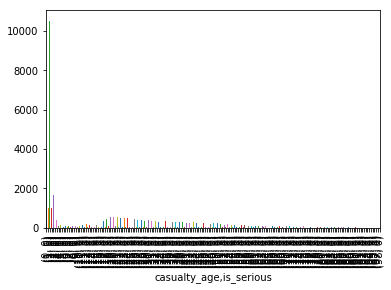

In [17]:
# numerical columns - are they useful? Do we want to do anything with them?

numericalColumns = ['num_vehicles', 'casualty_age']

for numCol in numericalColumns:
    grouped = df.groupby([numCol, 'is_serious']).size()
    grouped.plot.bar()

In [ ]:
# let's explore the date and time fields
# in their current format, they aren't very useful - we want to extract useful columns

monthMap = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 
            'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# write a function to take a date string of format DD-Mon-YY and extract the month as an integer
def getMonth(s):
    return monthMap[s.split('-')[1]]

# write a function to take a date string of format DD-Mon-YY and extract the full year as an integer
def getYear(s):
    return 2000 + int(s.split('-')[2])

# use these functions to add new columns to our dataframe
df['month'] = [getMonth(s) for s in df['accident_date']]
df['year'] = [getYear(s) for s in df['accident_date']]
df = df.drop(columns=['accident_date'])

df.head(5)

In [ ]:
# does the year matter? let's have a look at the distribution of slight vs serious cases by year

years = set(df.year.values)
x = []
y = []

for year in years:
    subDf = df[df.year == year]
    numSlight = len(subDf[subDf.casualty_severity == 'Slight'])
    numSerious = len(subDf[subDf.casualty_severity == 'Serious'])
    frac = numSerious/numSlight
    x.append(year)
    y.append(frac)

In [ ]:
plt.scatter(x,y)

# loose linear relationship but probably not enough to be useful
# will drop year column

df = df.drop(columns = ['year'])

In [ ]:
# write a function to take a 24hr HHMM time and get the hour as an int
# e.g. 1730 -> 17, 930 -> 9
# warning: leading zeros have been truncated, so 12.30am == 30
def getHour(n):
    s = str(n)
    if len(s) == 3:
        return int(s[0])
    elif len(s) == 2:
        return 0
    else:
        return int(s[0:2])

### Part 2d - categorical columns

In [ ]:
# categorical columns

In [ ]:
colsToExplore = ['num_vehicles', 'road_class', 'casualty_sex', 'road_surface']

for colte in colsToExplore:
    results = df.groupby([colte, 'casualty_severity'])[colte].agg(['count'])
    results.plot.bar(stacked=True)

In [ ]:
# creating better features from existing ones (e.g. weekend vs weekday, day bins)

# some features are useful but not in their current state

In [ ]:
# functions to get new features

monthMap = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 
            'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# write a function to take a date string of format DD-Mon-YY and extract the month as an integer
def getMonth(s):
    return s.split('-')[1]

# write a function to take a date string of format DD-Mon-YY and extract the full year as an integer
def getYear(s):
    return 2000 + int(s.split('-')[2])

# write a function to take a 24hr HHMM time and get the hour as an int
# e.g. 1730 -> 17, 930 -> 9
# warning: leading zeros have been truncated, so 12.30am == 30
def getHour(n):
    s = str(n)
    if len(s) == 3:
        return int(s[0])
    elif len(s) == 2:
        return 0
    else:
        return int(s[0:2])

# use these functions to add new columns to our dataframe
df['month'] = [getMonth(s) for s in df['accident_date']]
df['year'] = [getYear(s) for s in df['accident_date']]
df['hour'] = [getHour(n) for n in df['accident_time']]

In [ ]:
colName = 'month'
monthOrder = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
results = df.groupby(colName)[colName].agg(['count']).loc[monthOrder]
results.plot.bar()

In [ ]:
colName = 'hour'
results = df.groupby(colName).size()
results.plot.bar()

In [ ]:


monthMap = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
dayMap = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def getWeekday(s):
    month = monthMap[getMonth(s)]
    year = getYear(s)
    date = int(s.split('-')[0])
    dt = datetime.datetime(year, month, date)
    return dayMap[dt.isoweekday()]

df['weekday'] = [getWeekday(s) for s in df['accident_date']]

In [ ]:
colName = 'weekday'
dayOrder = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
results = df.groupby(colName)[colName].agg(['count']).loc[dayOrder]
results.plot.bar()

In [ ]:
# encoding categorical data

# some features are categorical and we need to encode this = one hot encoding!

In [ ]:
# normalization not necessary for decision trees but good to know

# in some methods you'll want to standardize numerical features
# example would be to take e.g. age in our model

# find mean and re-do as difference from mean, and visualise here

In [ ]:
#byAge = df.groupby('casualty_age')['casualty_age'].agg(['count']).reset_index(drop=False)
#byAge.plot.bar()

ages = list(df['casualty_age'].values)
plt.hist(ages)

In [ ]:
meanAge = np.mean(ages)
print(meanAge)

def norm(x,m):
    #newX = 0.001 if x == 0 else x
    return (x-m)/m

normAges = [norm(age,meanAge) for age in ages]

In [ ]:
plt.hist(normAges)

## Part 4 - training the model

### Part 4a - getting the data into X matrix and y vector form

In [ ]:
# getting into X and y shapes

columns = list(df.columns)

def encodeY(yString):
    return int(yString == "Serious")

y = np.array([encodeY(s) for s in df.casualty_severity.values])

### Part 4b - creating a train/test split

In [ ]:
# split up using skl and do it all k-fold wise
# check distribution of target class between train/test

### Part 4c - initialise classifier and train

In [ ]:
dtc = skl.tree.DecisionTreeClassifier()

## Part 5 - visualising the model

In [ ]:
# use graphviz and lime to visualise the model and show paths through the tree for new data?

## Part 6 - evaluating the model

In [ ]:
# binary classification metrics

# want good examples to demonstrate pros/cons of different metrics

In [ ]:
# testing on test data

## Part 7 - enhancing the model

In [ ]:
# random forest and ensemble methods

# extending to random forest and explaining significance of new parameters
# general explanation on advantages of ensemble methods# random forest and ensemble methods

In [ ]:
# re evaluation on new model